In [889]:
import argparse
import os
import random
import time
import math

# deep learning
import torch
import torch.nn as nn
import torch.nn.parallel
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim

# data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# signal processing
from scipy import signal
from scipy.stats import entropy

In [890]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [891]:
import socket
myHostName = socket.gethostname()
print(myHostName)

wifi-staff-172-24-36-25.net.auckland.ac.nz


In [892]:
device = torch.device("mps")

# number of channels the signal has
nc = 1

# Size of feature maps in discriminator
ndf = 64

# number of signals per iteration
batch_size = 32

# Number of training epochs
num_epochs = 200

# learning rate
lr = 0.001

prediction_type = "classification"

### Dataloader

In [893]:
class GWDataset(Dataset):
    def __init__(self, x, y):
        # convert to numpy array
        self.original_parameters = y
        self.parameters = self.original_parameters
        # self.augmented_parameters = np.empty(shape = (0, self.parameters.shape[1]))

        x = np.transpose(x)
        self.original_data = x
        self.data = self.original_data
        # self.augmented_data = np.empty(shape = (self.data.shape[0], 0))

        ### signal augmentation section ###
        
        temp_data = np.empty(shape = (256, 0)).astype('float32')

        for i in range(0, self.data.shape[1]):
            signal = self.data[:, i]
            signal = signal.reshape(1, -1)

            background_noise_segment = signal[:, 0:int(len(signal[0]) - 256)]
            signal = signal[:, int(len(signal[0]) - 256):len(signal[0])]

            temp_data = np.insert(temp_data, temp_data.shape[1], signal, axis=1)            

        self.data = temp_data
        ### end signal augmentation section ###

    def calc_stats(self):
        self.mean = self.data.mean()
        print('Dataset mean: ',  self.mean)
        self.std = np.std(self.data, axis=None)
        print('Dataset std: ',  self.std)

        self.parameter_mean = self.parameters.mean()
        print('Parameter mean: ',  self.parameter_mean)
        self.parameter_std = np.std(self.parameters, axis=None)
        print('Parameter std: ',  self.parameter_std)

    def get_common(self):
        self.common_ylim_signal = (self.data[:,:].min(), self.data[:,:].max())
        return self.common_ylim_signal
    
    def standardize_signal(self, signal):
        standardized_signal = (signal - self.mean) / self.std
        standardized_signal = standardized_signal / self.scaling_factor
        return standardized_signal
    
    def standardize_parameter(self, parameter):
        standardized_parameter = (parameter - self.parameter_mean) / self.parameter_std
        return standardized_parameter

    ### overloads ###
    def __len__(self):
        return self.data.shape[1]

    def __getitem__(self, idx):
        signal = self.data[:, idx]
        signal = signal.reshape(1, -1)

        parameter = self.parameters[idx,:]
        parameter = parameter.reshape(1, -1)

        # signal_standardized = self.standardize(signal)
        # parameter_standardized = self.standardize_parameter(parameter)

        return signal, parameter

In [894]:
x = pd.read_csv("../data/gw-raw-data/richers_1764.csv")
y = pd.read_csv("../data/gw-raw-data/richers_1764_parameters.csv")

# remove erroneous signals and select only beta_IC_b as label
keep_signals_idx = np.array(y[y['beta1_IC_b'] > 0].index)
y = y.iloc[keep_signals_idx,:]
y = y['beta1_IC_b']

print(y.shape)

ranges = [0, 0.06, 0.17, 1]
labels = [0, 1, 2]

y = pd.cut(y, bins=ranges, labels=labels).astype('int')
y = y.values

print(y.shape)
print(y)

# y = torch.nn.functional.one_hot(y, 3)
y = np.eye(len(labels))[y]

print(y)

# select continuous beta_IC_b values for now
# y = y[['beta1_IC_b']].astype('float32')
# bin labels to get discretised data
# y['beta1_IC_b_bins'] = pd.qcut(y['beta1_IC_b'], q=10, labels=False)
# y = y[['beta1_IC_b_bins']].astype('float32')
# convert to numpy array
# y = y.values

# drop corresponding signals which have erroneous parameter values
x = x.iloc[:,keep_signals_idx]
x = x.values.astype('float32')

# only transpore x due to compatibility issues with train_test_split
x = np.transpose(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=manualSeed)

train_data = GWDataset(x_train, y_train)
test_data = GWDataset(x_test, y_test)

# train_data.calc_stats()
# test_data.calc_stats()

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

(1684,)
(1684,)
[0 0 0 ... 1 1 1]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


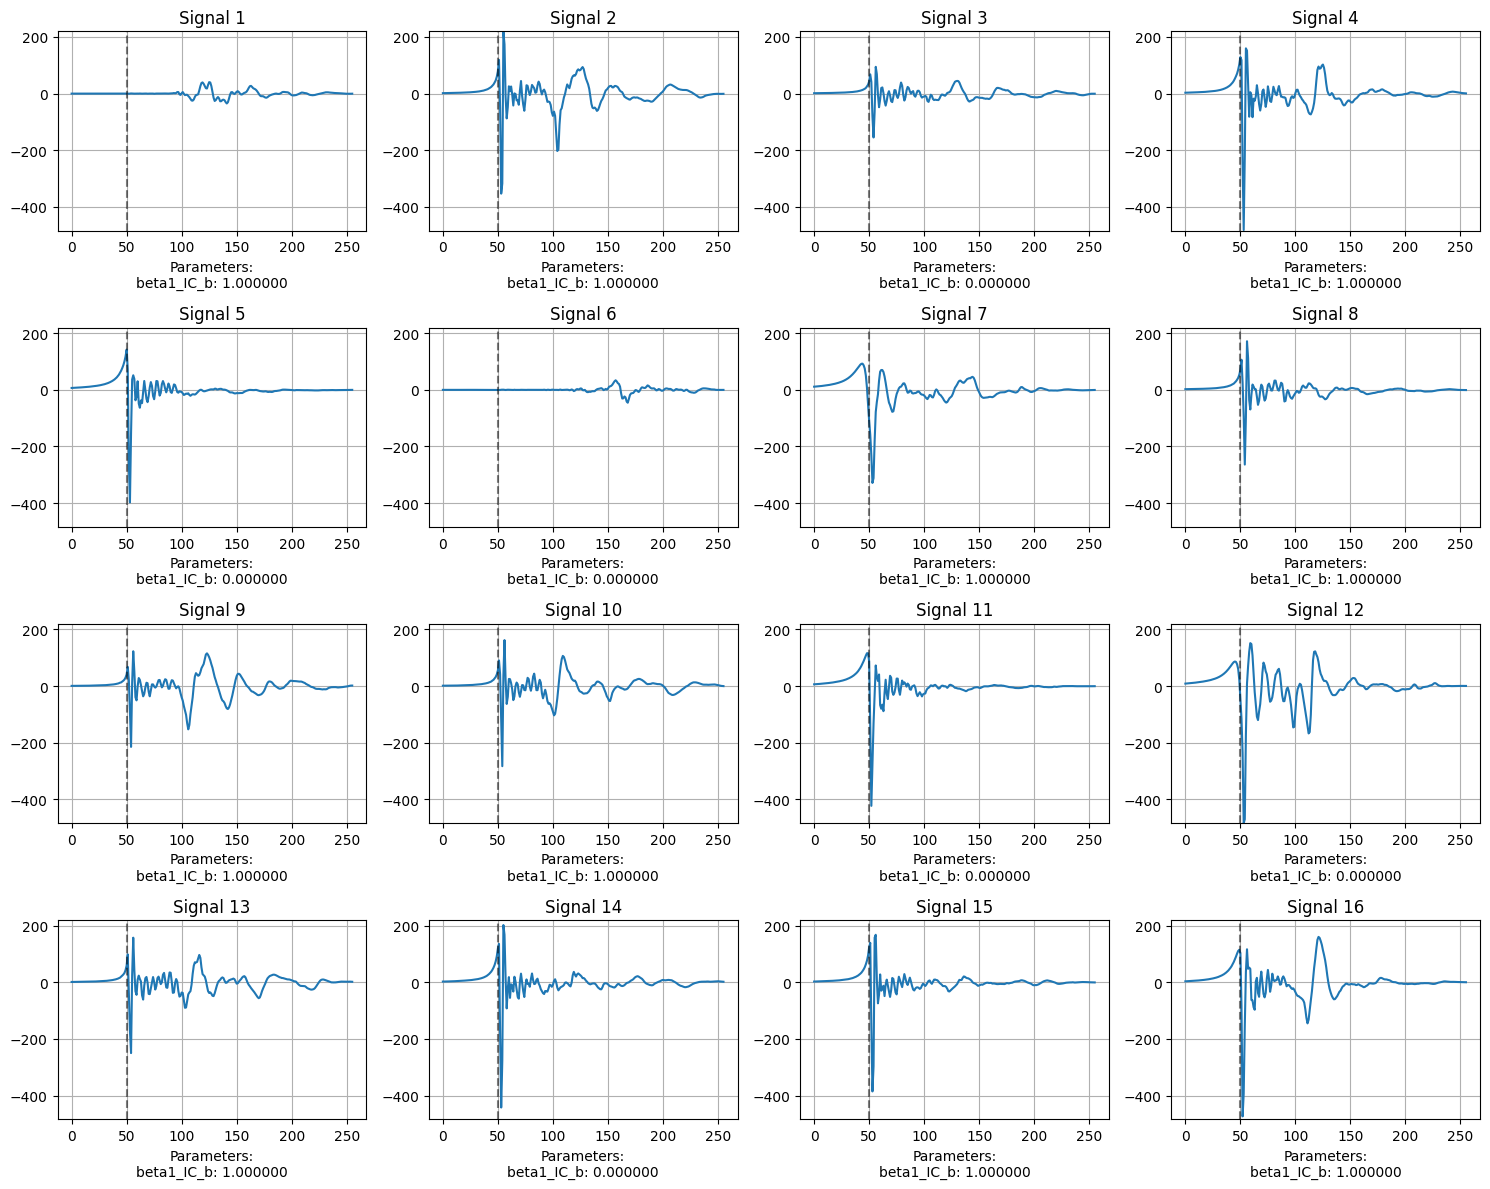

In [895]:
real_signals_batch, real_parameter_batch  = next(iter(train_loader))

common_ylim = (real_signals_batch[:,:,:].min(), real_signals_batch[:,:,:].max())
parameter_names = ['beta1_IC_b']

def plot_waveforms(real_signals_batch, real_parameter_batch):
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    axes = axes.flatten()

    # Plot each signal on a separate subplot
    for i, ax in enumerate(axes):
        x = np.arange(real_signals_batch.size(dim=2))
        y = real_signals_batch[i, :, :].flatten()
        ax.plot(x, y)

        ax.axvline(x=50, color='black', linestyle='--', alpha=0.5)
        ax.set_title(f'Signal {i + 1}')
        ax.grid(True)
        ax.set_ylim(common_ylim)

        # Get parameter values as a NumPy array
        parameters = real_parameter_batch[i, :].numpy()[0]

        # Combine parameter names and values, format as a string
        parameters_with_names = f'{parameter_names[0]}: {parameters[0]:.6f}'
        ax.set_xlabel(f'Parameters:\n{parameters_with_names}')

    for i in range(512, 8 * 4):
        fig.delaxes(axes[i])

    plt.tight_layout()

    plt.show()
    
plot_waveforms(real_signals_batch, real_parameter_batch)

### Weight Initialisation

In [896]:
# custom weights initialization called on classifier
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Classifier Network

In [897]:
class Discriminator(nn.Module):
        def __init__(self):
            super(Discriminator, self).__init__()
            self.main = nn.Sequential(
                nn.Conv1d(nc, ndf, kernel_size=16, stride=2, padding=1, bias=False),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf, ndf * 2, kernel_size=8, stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 2),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 2, ndf * 4, kernel_size=4,
                        stride=2, padding=1, bias=False),
                nn.BatchNorm1d(ndf * 4),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout1d(0.2),

                nn.Conv1d(ndf * 4, ndf * 8, kernel_size=4,
                        stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 8),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 8, ndf * 16, kernel_size=4,
                #         stride=2, padding=0, bias=False),
                # nn.BatchNorm1d(ndf * 16),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 16, ndf * 32, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 32),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),

                # nn.Conv1d(ndf * 32, ndf * 64, kernel_size=4,
                #         stride=2, padding=1, bias=False),
                # nn.BatchNorm1d(ndf * 64),
                # nn.LeakyReLU(0.2, inplace=True),
                # nn.Dropout1d(0.2),
                
                # nn.Conv1d(ndf * 64, nc, kernel_size=4,
                #         stride=2, padding=0, bias=False)
            )

            self.fc_reg = nn.Sequential(
                nn.LazyLinear(1),
            )

            self.fc_class = nn.Sequential(
                nn.LazyLinear(3),
                nn.Softmax(dim=1),
            )

        def forward(self, x):
            x = self.main(x)
            x = x.view(x.shape[0], -1)  # Flatten the tensor
            if (prediction_type == "regression"):
                x = self.fc_reg(x)
            else:
                x = self.fc_class(x)
            return x

In [898]:
net = Discriminator().to(device)
net.apply(weights_init)

print(net)

model = Discriminator()
summary(model, input_size=(1, 256))

Discriminator(
  (main): Sequential(
    (0): Conv1d(1, 64, kernel_size=(16,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout1d(p=0.2, inplace=False)
    (3): Conv1d(64, 128, kernel_size=(8,), stride=(2,), padding=(1,), bias=False)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout1d(p=0.2, inplace=False)
    (7): Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout1d(p=0.2, inplace=False)
    (11): Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
  )
  (fc_reg): Sequential(
    (0): LazyLinear(in_features=0, out_features=1, bias=True)
  )
  (fc_class): Sequential(
    (0): LazyLinear(in_features=0, out_features=3,

/Users/tarineccleston/Documents/software-ds/gravitational-waves/gw-env/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Loss functions and Optimisers

In [899]:
if (prediction_type == "regression"):
    criterion = nn.MSELoss()
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

### Training

In [900]:
C_gradients = []
C_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.float32)
        labels = labels.squeeze(1)

        # print(inputs)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # save losses and gradients for plotting later
        # C_gradients.append([param.grad.norm().item() for param in net.parameters()])
        # C_losses.append(loss.item())
        running_loss += loss.item()

    print("Epoch: "f'{epoch + 1} loss: {running_loss:.3f}')
    running_loss = 0.0

print('Finished Training')

Epoch: 1 loss: 50.012
Epoch: 2 loss: 49.012
Epoch: 3 loss: 49.026
Epoch: 4 loss: 48.528
Epoch: 5 loss: 48.483
Epoch: 6 loss: 48.113
Epoch: 7 loss: 48.348
Epoch: 8 loss: 48.031
Epoch: 9 loss: 47.771
Epoch: 10 loss: 48.019
Epoch: 11 loss: 47.800
Epoch: 12 loss: 47.766
Epoch: 13 loss: 47.232
Epoch: 14 loss: 47.270
Epoch: 15 loss: 47.454
Epoch: 16 loss: 47.095
Epoch: 17 loss: 46.912
Epoch: 18 loss: 46.807
Epoch: 19 loss: 47.076
Epoch: 20 loss: 47.072
Epoch: 21 loss: 46.673
Epoch: 22 loss: 46.392
Epoch: 23 loss: 46.489
Epoch: 24 loss: 46.444
Epoch: 25 loss: 46.450
Epoch: 26 loss: 46.186
Epoch: 27 loss: 46.132
Epoch: 28 loss: 45.923
Epoch: 29 loss: 45.590
Epoch: 30 loss: 45.861
Epoch: 31 loss: 45.929
Epoch: 32 loss: 45.779
Epoch: 33 loss: 45.389
Epoch: 34 loss: 45.866
Epoch: 35 loss: 45.595
Epoch: 36 loss: 45.347
Epoch: 37 loss: 45.144
Epoch: 38 loss: 45.514
Epoch: 39 loss: 45.259
Epoch: 40 loss: 44.822
Epoch: 41 loss: 45.179
Epoch: 42 loss: 44.756
Epoch: 43 loss: 44.918
Epoch: 44 loss: 44.9

### Gradients

Maybe visualise this later. Not sure what's going on. 

In [901]:
# # get the total number of layers in the classifier
# C_gradients = np.array(C_gradients)
# num_layers = C_gradients.shape[1]

# # Plot the gradients over training epochs
# plt.figure(figsize=(10, 6))
# for i in range(num_layers):
#     # Calculate alpha value based on layer index
#     alpha = 1 - (i / num_layers)  # Higher layers are more transparent
#     plt.plot(C_gradients[:, i], label=f'Layer {i}', alpha=alpha, color=(1, 0, 0, alpha))

# plt.xlabel('iterations')
# plt.ylabel('Gradient Magnitude')
# plt.title('Classifier Gradients')
# plt.legend()
# plt.show()

### Loss

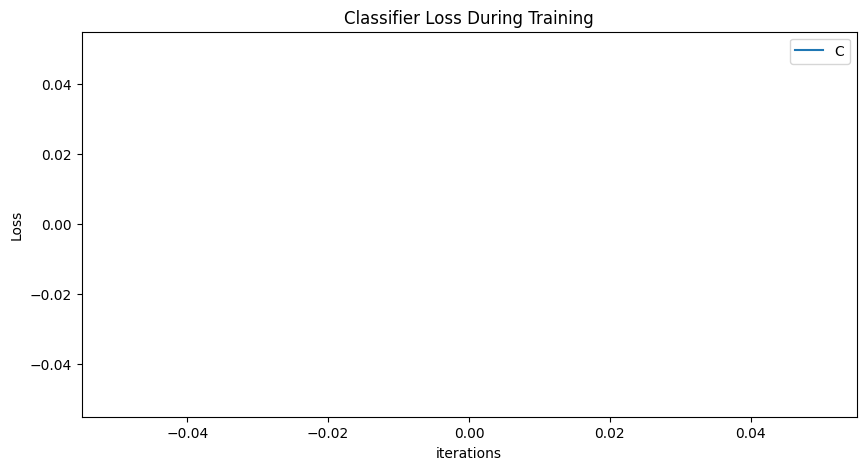

In [902]:
plt.figure(figsize=(10,5))
plt.title("Classifier Loss During Training")
plt.plot(C_losses,label="C")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Testing

In [903]:
dataiter = iter(test_loader)
data, labels = next(dataiter)

print(labels)

tensor([[[0., 1., 0.]],

        [[1., 0., 0.]],

        [[1., 0., 0.]],

        [[0., 1., 0.]],

        [[1., 0., 0.]],

        [[0., 1., 0.]],

        [[1., 0., 0.]],

        [[0., 0., 1.]],

        [[0., 0., 1.]],

        [[0., 1., 0.]],

        [[1., 0., 0.]],

        [[0., 1., 0.]],

        [[0., 1., 0.]],

        [[0., 1., 0.]],

        [[0., 1., 0.]],

        [[0., 1., 0.]],

        [[0., 1., 0.]],

        [[1., 0., 0.]],

        [[1., 0., 0.]],

        [[1., 0., 0.]],

        [[1., 0., 0.]],

        [[1., 0., 0.]],

        [[0., 1., 0.]],

        [[0., 1., 0.]],

        [[0., 1., 0.]],

        [[0., 1., 0.]],

        [[1., 0., 0.]],

        [[0., 1., 0.]],

        [[0., 0., 1.]],

        [[0., 1., 0.]],

        [[0., 1., 0.]],

        [[0., 1., 0.]]], dtype=torch.float64)


In [911]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device, dtype=torch.float32)
        labels = labels.to(device, dtype=torch.float32)
        labels = labels.squeeze(1)

        # print(data)
        
        # calculate outputs by running images through the network
        outputs = net(inputs)
        print(outputs)
        # print(labels)
        print(inputs.shape[0])
        for i in range(inputs.shape[0]):
            predicted_index = outputs[i].argmax(dim=0, keepdim=True)
            print(predicted_index.item())
        # predicted_labels = torch.argmax(outputs, dim=1)
        # print(predicted_labels)
    

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

tensor([[3.0597e-01, 6.9403e-01, 5.1422e-06],
        [9.9300e-01, 6.9370e-03, 6.3977e-05],
        [9.6189e-01, 3.7874e-02, 2.3317e-04],
        [7.4637e-01, 2.5302e-01, 6.0961e-04],
        [4.3119e-02, 9.5638e-01, 4.9933e-04],
        [5.7798e-01, 4.2195e-01, 6.9866e-05],
        [4.6545e-03, 9.9532e-01, 2.5261e-05],
        [8.4885e-01, 1.5109e-01, 5.8840e-05],
        [1.9166e-01, 8.0791e-01, 4.3167e-04],
        [7.7358e-01, 2.2577e-01, 6.5166e-04],
        [2.9714e-04, 9.9967e-01, 2.9472e-05],
        [8.5020e-01, 1.4971e-01, 8.8172e-05],
        [5.9100e-02, 9.4079e-01, 1.1317e-04],
        [1.5736e-01, 8.4252e-01, 1.2270e-04],
        [9.9324e-01, 6.7437e-03, 1.4146e-05],
        [4.6478e-01, 5.3499e-01, 2.2588e-04],
        [8.4327e-03, 9.9156e-01, 7.3095e-06],
        [9.9979e-01, 1.9189e-04, 1.4817e-05],
        [9.8775e-01, 1.2125e-02, 1.2076e-04],
        [8.9714e-01, 1.0238e-01, 4.7825e-04],
        [9.9952e-01, 4.7709e-04, 1.7108e-06],
        [9.4122e-01, 5.8735e-02, 4

ZeroDivisionError: integer division or modulo by zero

In [ ]:
outputs = net(data)
print(outputs)

TypeError: conv1d() received an invalid combination of arguments - got (list, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list of [Tensor, Tensor]!, !Parameter!, !NoneType!, !tuple of (int,)!, !tuple of (int,)!, !tuple of (int,)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list of [Tensor, Tensor]!, !Parameter!, !NoneType!, !tuple of (int,)!, !tuple of (int,)!, !tuple of (int,)!, int)
